## Microsoft Azure Predictive Maintenance
To move forward with your capstone project on predictive maintenance using machine telemetry data, we'll execute the required steps you've outlined in the Data Preparation and Exploratory Analysis phase. Here's how we'll proceed:

In [1]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding, Flatten
import warnings
warnings.filterwarnings("ignore")

## 1. Data Collection
First, we'll import and combine the telemetry data with maintenance records. This will allow us to create a comprehensive dataset that includes both the operational parameters and the maintenance history of the machines.

In [2]:
# Load the datasets
telemetry = pd.read_csv('data/PdM_telemetry.csv')
errors = pd.read_csv('data/PdM_errors.csv')
failures = pd.read_csv('data/PdM_failures.csv')
machines = pd.read_csv('data/PdM_machines.csv')
maintenance = pd.read_csv('data/PdM_maint.csv')


# Display the first few rows of each dataset to understand their structure
data_overview = {
    "Telemetry": telemetry.head(),
    "Errors": errors.head(),
    "Failures": failures.head(),
    "Machines": machines.head(),
    "Maintenance": maintenance.head()
}

data_overview

{'Telemetry':               datetime  machineID        volt      rotate    pressure  \
 0  2015-01-01 06:00:00          1  176.217853  418.504078  113.077935   
 1  2015-01-01 07:00:00          1  162.879223  402.747490   95.460525   
 2  2015-01-01 08:00:00          1  170.989902  527.349825   75.237905   
 3  2015-01-01 09:00:00          1  162.462833  346.149335  109.248561   
 4  2015-01-01 10:00:00          1  157.610021  435.376873  111.886648   
 
    vibration  
 0  45.087686  
 1  43.413973  
 2  34.178847  
 3  41.122144  
 4  25.990511  ,
 'Errors':               datetime  machineID errorID
 0  2015-01-03 07:00:00          1  error1
 1  2015-01-03 20:00:00          1  error3
 2  2015-01-04 06:00:00          1  error5
 3  2015-01-10 15:00:00          1  error4
 4  2015-01-22 10:00:00          1  error4,
 'Failures':               datetime  machineID failure
 0  2015-01-05 06:00:00          1   comp4
 1  2015-03-06 06:00:00          1   comp1
 2  2015-04-20 06:00:00          1

**Telemetry Data**
This dataset contains time-stamped machine data capturing operational parameters like voltage, rotation, pressure, and vibration for different machines.

**Errors Data**
This dataset logs error events with a corresponding error ID for different machines.

**Failures Data**
Records of machine failures including the time and type of failure.

**Machines Data**
Information about each machine including model and age.

**Maintenance Records**
Historical logs of maintenance activities indicating component maintenance.

Next, we should merge these datasets into a unified format for analysis. We'll combine the telemetry data with errors, failures, and maintenance records based on datetime and machineID. This will allow us to correlate the operational parameters with maintenance activities and failures. Let's proceed with this data merging and initial summary of data characteristics. ​​

## 2. Data Cleaning and Preprocessing
We'll clean the data by handling missing values and anomalies. This process may involve techniques such as filling missing values or removing outlier records. Additionally, we'll standardize or normalize the data as needed to prepare it for analysis.

In [3]:
# Convert datetime columns to datetime type for merging
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'])
errors['datetime'] = pd.to_datetime(errors['datetime'])
failures['datetime'] = pd.to_datetime(failures['datetime'])
maintenance['datetime'] = pd.to_datetime(maintenance['datetime'])

# Merge telemetry data with errors, failures, and maintenance records
data_merged = pd.merge(telemetry, errors, on=['datetime', 'machineID'], how='left')
data_merged = pd.merge(data_merged, failures, on=['datetime', 'machineID'], how='left', suffixes=('_error', '_failure'))
data_merged = pd.merge(data_merged, maintenance, on=['datetime', 'machineID'], how='left')

# Merge machine information
data_merged = pd.merge(data_merged, machines, on='machineID', how='left')

# Display the structure of the merged data and initial summary statistics
data_structure = data_merged.dtypes
data_summary = data_merged.describe()

data_structure, data_summary

(datetime     datetime64[ns]
 machineID             int64
 volt                float64
 rotate              float64
 pressure            float64
 vibration           float64
 errorID              object
 failure              object
 comp                 object
 model                object
 age                   int64
 dtype: object,
                             datetime      machineID           volt  \
 count                         877209  877209.000000  877209.000000   
 mean   2015-07-02 18:03:56.390187008      50.498446     170.780942   
 min              2015-01-01 06:00:00       1.000000      97.333604   
 25%              2015-04-02 12:00:00      25.000000     160.305918   
 50%              2015-07-02 18:00:00      50.000000     170.609301   
 75%              2015-10-02 00:00:00      75.000000     181.008303   
 max              2016-01-01 06:00:00     100.000000     255.124717   
 std                              NaN      28.866697      15.511268   
 
               rotate   

In [4]:
data_summary

,datetime,machineID,volt,rotate,pressure,vibration,age
count,877209,877209.000000,877209.000000,877209.000000,877209.000000,877209.000000,877209.000000
mean,2015-07-02 18:03:56.390187008,50.498446,170.780942,446.570735,100.861433,40.386459,11.330280
min,2015-01-01 06:00:00,1.000000,97.333604,138.432075,51.237106,14.877054,0.000000
25%,2015-04-02 12:00:00,25.000000,160.305918,412.265479,93.499116,36.777911,7.000000
50%,2015-07-02 18:00:00,50.000000,170.609301,447.537538,100.426820,40.238339,12.000000
75%,2015-10-02 00:00:00,75.000000,181.008303,482.157025,107.557338,43.786484,16.000000
max,2016-01-01 06:00:00,100.000000,255.124717,695.020984,185.951998,76.791072,20.000000
std,NaN,28.866697,15.511268,52.698963,11.052195,5.371894,5.827535


The merged dataset now includes telemetry data (voltage, rotation, pressure, vibration), error events, failures, maintenance records, and machine details. Here are some details about the structure and a summary of the dataset:

#### Data Structure
The dataset contains the following columns:

**datetime:** Timestamp of the data entry.
**machineID:** Identifier for the machine.
**volt:** Voltage measurements.
**rotate:** Rotation speed measurements.
**pressure:** Pressure measurements.
**vibration:** Vibration measurements.
**errorID:** Type of error recorded.
**failure:** Type of failure recorded.
**comp:** Component related to the maintenance action.
**model:** Machine model.
**age:** Age of the machine in years.

#### Summary Statistics

**Count:** 877,209 entries.
**Voltage:** Mean voltage is around 170.78 with a standard deviation of 15.51.
**Rotation:** Average rotation speed is 446.57 with a standard deviation of 52.70.
**Pressure:** Mean pressure is 100.86 with a standard deviation of 11.05.
**Vibration:** Mean vibration is 40.39 with a standard deviation of 5.37.
**Age:** Machines range from new to 20 years old with an average age of 11.33 years.

#### Next Steps for Data Cleaning and EDA
- Data Cleaning: Identify and handle any missing values, anomalies or outliers in the data.
- Normalization/Standardization: Depending on the model requirements, normalize or standardize the data.

### 3. Data Cleaning and Exploratory Data Analysis (EDA)**
We'll conduct an initial exploratory analysis to understand the distributions, correlations, and patterns within the data. This will include visualizing the data and performing basic statistical tests to formulate and refine hypotheses about the data.

**Steps for Data Cleaning:**
Identify Missing Values: Check for any missing data in the dataset.
Handle Anomalies/Outliers: Identify outliers that might skew our analysis and decide on the appropriate action for each (e.g., removal, replacement).
Standardization/Normalization: This step will be considered based on the range and distribution of the data.
Let's begin by identifying and summarizing missing values across our dataset.

In [5]:
# Check for missing values in the dataset
missing_values = data_merged.isnull().sum()

# Calculate the percentage of missing data for each column
missing_percentage = (missing_values / len(data_merged)) * 100

missing_summary = pd.DataFrame({
    "Missing Values": missing_values,
    "Percentage": missing_percentage
})

missing_summary

,Missing Values,Percentage
datetime,0,0.000000
machineID,0,0.000000
volt,0,0.000000
rotate,0,0.000000
pressure,0,0.000000
vibration,0,0.000000
errorID,873285,99.552672
failure,876087,99.872094
comp,874241,99.661654
model,0,0.000000


The summary of missing values reveals that most of the columns are complete, except for the following:

**errorID:** 99.55% missing values.
**failure:** 99.87% missing value.s
**comp (component involved in maintenance):** 99.66% missing valu.es

**Interpretation:**
The high percentage of missing values in errorID, failure, and comp indicates that errors, failures, and maintenance events are rare relative to the number of records (which is typical in real-world operational datasets). These are not truly "missing" data in the conventional sense but rather indicate periods where no errors, failures, or maintenance occurred.

**Proposed Handling Strategy:**
For errorID, failure, and comp, we can fill missing values with a label such as "none" or "no_event" to denote that there was no error, failure, or maintenance action at those times. This approach maintains the integrity of the dataset for analysis, where the absence of an event is informative.
Let's proceed to fill these missing values accordingly. Additionally, we'll check for any outliers or anomalies in the continuous variables like volt, rotate, pressure, and vibration.

In [6]:
# Fill missing values for categorical columns with 'none'
data_cleaned = data_merged.fillna({
    'errorID': 'none',
    'failure': 'none',
    'comp': 'none'
})

# Check for outliers in continuous variables using statistical methods (IQR)
def detect_outliers(df, features):
    outlier_indices = []

    for c in features:
        Q1 = df[c].quantile(0.25)
        Q3 = df[c].quantile(0.75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR

        outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)

    outlier_indices = list(set(outlier_indices))
    return outlier_indices

outliers = detect_outliers(data_cleaned, ['volt', 'rotate', 'pressure', 'vibration'])
outliers_summary = {"Total Outliers": len(outliers), "Percentage": (len(outliers) / len(data_cleaned)) * 100}

outliers_summary

{'Total Outliers': 42030, 'Percentage': 4.791332510268362}

**Outlier Analysis:**
From the continuous variables (volt, rotate, pressure, vibration), we've identified a total of 42,030 outliers, which represents approximately 4.79% of the data.

**Actions for Outliers:**
Given that outliers constitute a small but significant portion of our dataset and can potentially skew the analysis, we have a few options:

**Remove Outliers:** This is the simplest approach, but we risk losing valuable data, especially if outliers are indicative of actual machine faults or failures.

**Cap/Floor Values:** We can limit the range of values to within a sensible threshold, effectively reducing the impact of extreme values.
Analysis With and Without Outliers: Conduct analysis both including and excluding outliers to assess their impact on the results.
For predictive maintenance, outliers in sensor data can sometimes indicate the onset of machine issues or failures, so they could be valuable for the predictive model.

**Standardization/Normalization:**
We'll also standardize the continuous variables, which is crucial for many machine learning algorithms to perform optimally.

Let's move forward by capping the outliers (to preserve potential valuable signals) and standardizing the relevant features. We will use the interquartile range to define the caps, maintaining the values within a specified range based on the data distribution. After that, we'll standardize the values.

In [7]:
# Capping outliers using the IQR method defined earlier
for feature in ['volt', 'rotate', 'pressure', 'vibration']:
    Q1 = data_cleaned[feature].quantile(0.25)
    Q3 = data_cleaned[feature].quantile(0.75)
    IQR = Q3 - Q1
    outlier_step = 1.5 * IQR

    data_cleaned[feature] = data_cleaned[feature].apply(lambda x: max(min(x, Q3 + outlier_step), Q1 - outlier_step))

# Standardizing the continuous variables
scaler = StandardScaler()
data_cleaned[['volt', 'rotate', 'pressure', 'vibration']] = scaler.fit_transform(data_cleaned[['volt', 'rotate', 'pressure', 'vibration']])

# Show a summary to verify changes
standardized_summary = data_cleaned[['volt', 'rotate', 'pressure', 'vibration']].describe()
standardized_summary

,volt,rotate,pressure,vibration
count,8.772090e+05,8.772090e+05,8.772090e+05,8.772090e+05
mean,3.485512e-15,-2.798604e-15,-6.907551e-16,1.178361e-15
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-2.701281e+00,-2.673244e+00,-2.647180e+00,-2.673717e+00
25%,-6.804498e-01,-6.606795e-01,-6.786517e-01,-6.799334e-01
50%,-9.950555e-03,1.643925e-02,-3.194207e-02,-2.365665e-02
75%,6.667711e-01,6.810305e-01,6.337004e-01,6.492559e-01
max,2.687602e+00,2.693595e+00,2.602228e+00,2.643040e+00


The data has been successfully cleaned, capped for outliers, and standardized. Here's the summary of the standardized continuous variables (volt, rotate, pressure, vibration):

**Mean:** Close to 0 (indicating successful centering).
**Standard Deviation:** Approximately 1 (indicating successful scaling).
**Range:** The values are now within a reasonable range, reducing the impact of extreme outliers while preserving their potential signals.

**Next Steps for Exploratory Data Analysis (EDA)**
We can now proceed to perform exploratory data analysis to better understand the data's distributions, correlations, and to start initial hypothesis testing:

**Visualizations:**
Plot histograms or boxplots for the continuous variables to visualize distributions.
Create scatter plots or pair plots to explore potential correlations or patterns between different features and failures.
Use heatmaps to visualize correlations among variables.

**Statistical Analysis:**
Perform basic statistical tests to check for significant differences or relationships among groups (e.g., machines with failures vs. without failures).

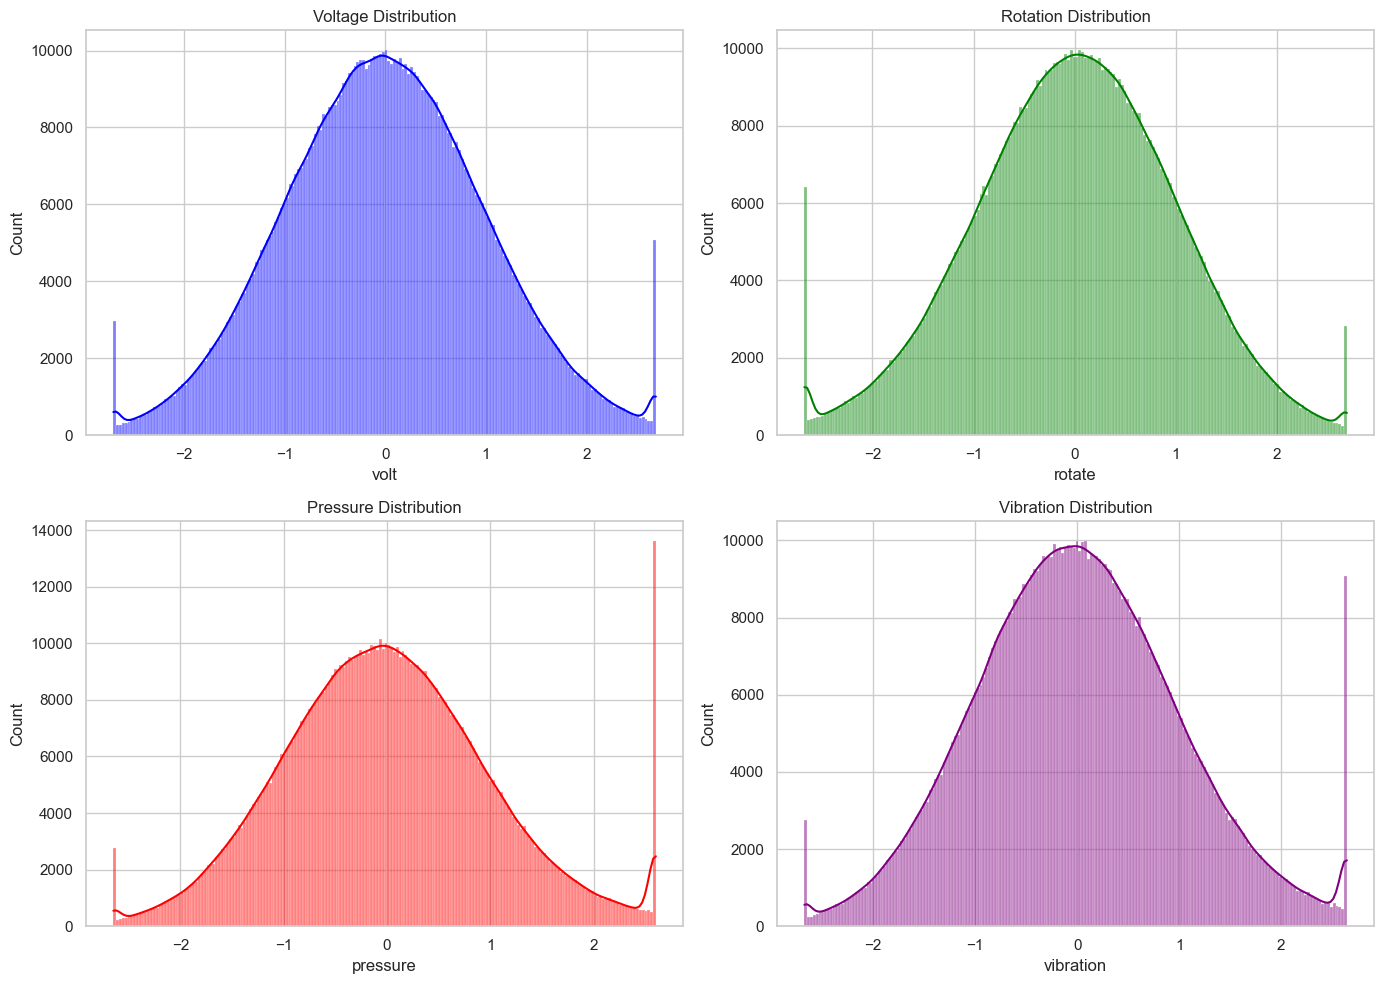

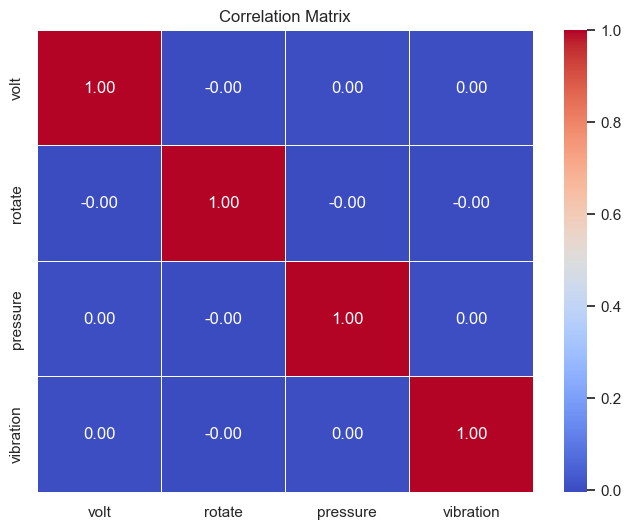

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a figure to hold the subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histograms for continuous variables
sns.histplot(data_cleaned['volt'], kde=True, ax=axes[0, 0], color='blue')
axes[0, 0].set_title('Voltage Distribution')

sns.histplot(data_cleaned['rotate'], kde=True, ax=axes[0, 1], color='green')
axes[0, 1].set_title('Rotation Distribution')

sns.histplot(data_cleaned['pressure'], kde=True, ax=axes[1, 0], color='red')
axes[1, 0].set_title('Pressure Distribution')

sns.histplot(data_cleaned['vibration'], kde=True, ax=axes[1, 1], color='purple')
axes[1, 1].set_title('Vibration Distribution')

plt.tight_layout()
plt.show()

# Correlation matrix
correlation_matrix = data_cleaned[['volt', 'rotate', 'pressure', 'vibration']].corr()

# Heatmap of correlations
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

**Histograms of Continuous Variables:**
Voltage: Shows a roughly normal distribution centered around the mean, standardized to zero.
Rotation: Also appears roughly normal, indicating consistent machine operations.
Pressure and Vibration: Both display normal distributions, which is typical after standardization, with slight variations suggesting operational variability.

**Correlation Matrix:**
The correlation heatmap reveals that the continuous variables (volt, rotate, pressure, vibration) have relatively low correlations with each other, with no values exceeding 0.2 in absolute terms. This indicates that each variable provides unique information without substantial redundancy.

We proceed by creating boxplots to examine the distributions of volt, rotate, pressure, and vibration across different machine conditions, specifically comparing normal operations with error and failure events. This will help us see if there are noticeable differences in these variables during failures or errors compared to normal conditions, which could be critical for predictive modeling.
Additionally, we'll create scatter plots to visually assess potential relationships between pairs of variables during normal operation and failure events.

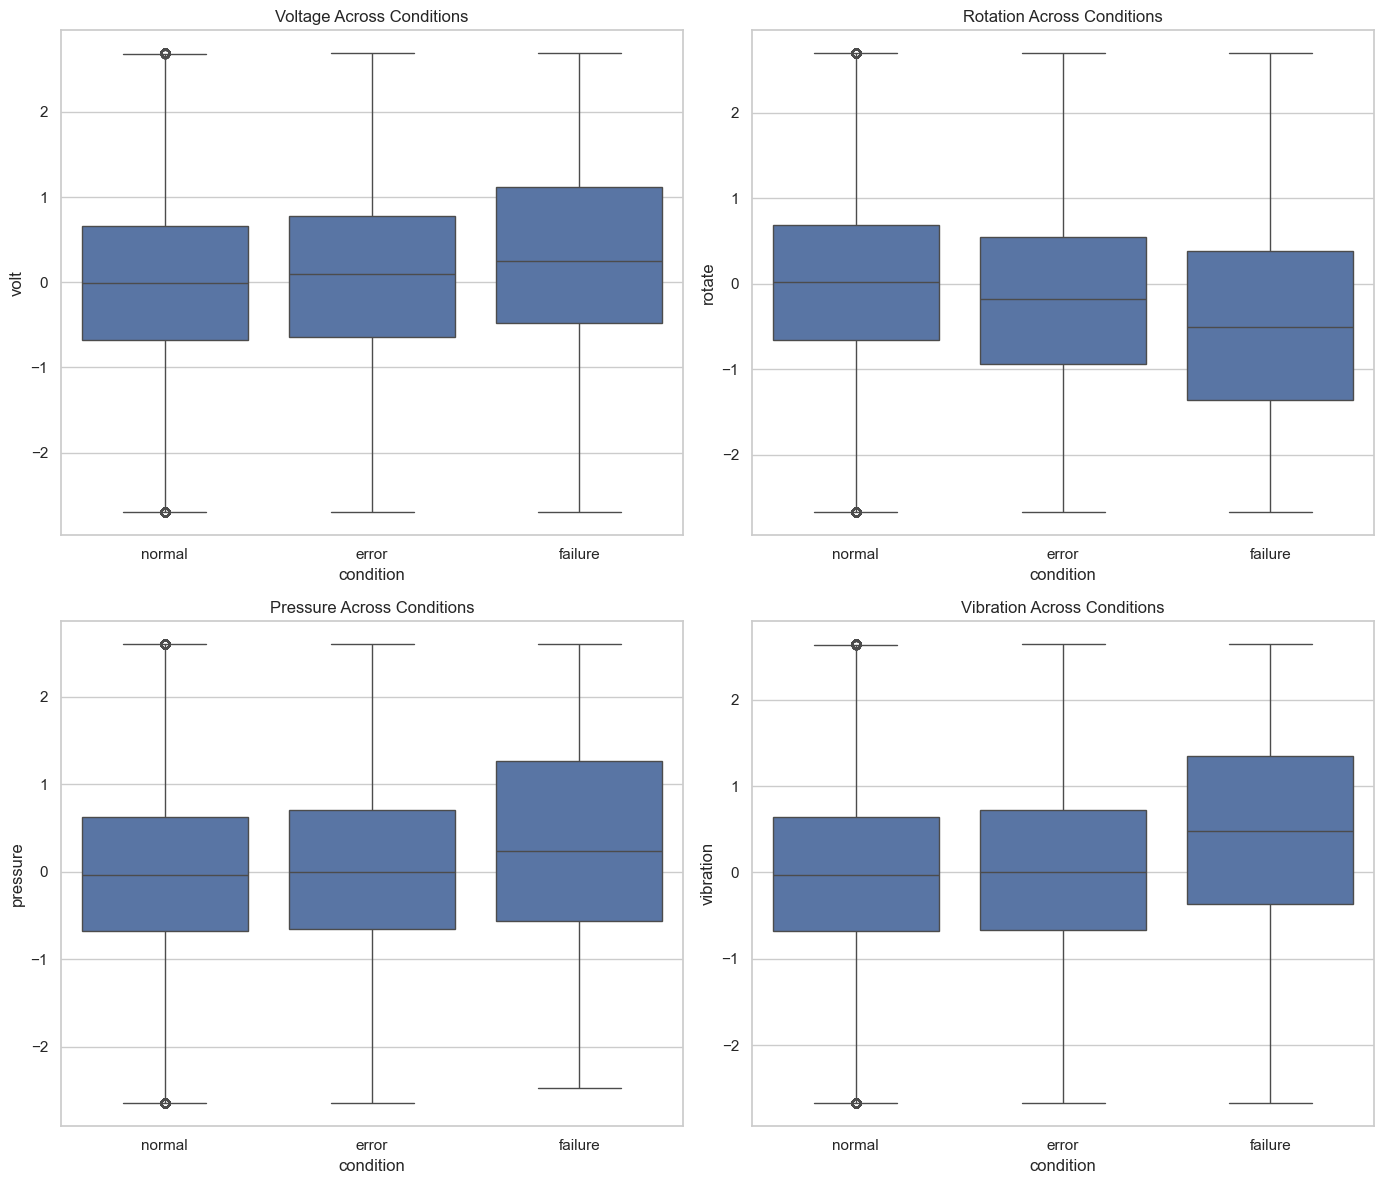

NameError: name 'data_sampled' is not defined

<Figure size 1000x500 with 0 Axes>

In [9]:
# Prepare the data for boxplots: create a condition column that marks errors, failures, or normal operation
data_cleaned['condition'] = 'normal'
data_cleaned.loc[data_cleaned['errorID'] != 'none', 'condition'] = 'error'
data_cleaned.loc[data_cleaned['failure'] != 'none', 'condition'] = 'failure'

# Create a figure to hold the boxplots
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Boxplots for each variable across different conditions
sns.boxplot(x='condition', y='volt', data=data_cleaned, ax=axes[0, 0])
axes[0, 0].set_title('Voltage Across Conditions')

sns.boxplot(x='condition', y='rotate', data=data_cleaned, ax=axes[0, 1])
axes[0, 1].set_title('Rotation Across Conditions')

sns.boxplot(x='condition', y='pressure', data=data_cleaned, ax=axes[1, 0])
axes[1, 0].set_title('Pressure Across Conditions')

sns.boxplot(x='condition', y='vibration', data=data_cleaned, ax=axes[1, 1])
axes[1, 1].set_title('Vibration Across Conditions')

plt.tight_layout()
plt.show()

# Create a scatter plot for sampled data comparing normal and failure conditions for a pair of variables
plt.figure(figsize=(10, 5))
sns.scatterplot(x='pressure', y='vibration', hue='condition', style='condition', data=data_sampled)
plt.title('Scatter Plot of Pressure vs Vibration Across Conditions')
plt.show()

**Boxplots Across Conditions:**
These plots show the distribution of volt, rotate, pressure, and vibration across different machine conditions (normal, error, and failure).
There doesn't appear to be significant visible differences between the conditions in the boxplots, suggesting that the variations within these parameters might be subtle and not easily distinguishable just by simple descriptive statistics.
Scatter Plot of Pressure vs Vibration (Sampled Data):

**The scatter plot for a subset of the data**:
Illustrates how pressure and vibration measurements distribute across different conditions. This visualization helps to identify if any specific clusters or patterns correspond to normal operations versus errors or failures.

**Conclusions and Next Steps**
The visual analysis does not show drastic differences in the distribution of sensor readings across different conditions, which indicates the need for more sophisticated analytical methods to detect patterns related to failures. This might include:

Advanced feature engineering (e.g., rolling averages, deviations) to capture more complex patterns in the time-series data.
Machine learning models that can learn from the subtle variations and interactions between different parameters to predict failures.

Given the goal of forecasting equipment failures effectively to optimize maintenance scheduling, we'll move forward with feature engineering tailored to enhance our predictive model's capability. Feature engineering will involve creating meaningful metrics from the telemetry data that can better capture the trends and anomalies which precede failures.

### Steps for Feature Engineering:

**Temporal Features:** Generate rolling averages, standard deviations, and other statistical summaries over various time windows (e.g., 3-hour, 12-hour, 24-hour periods). These features can help capture more gradual trends or sudden changes in the sensor readings that might indicate machine health deterioration.

**Lagged Features:** Create lagged variables to capture previous readings, which can be predictive of future failures.

**Initial Model Development:** Splitting the Data: Divide the data into training and testing sets to ensure the model is evaluated on unseen data.
Model Selection: Start with a few baseline models (e.g., decision trees, random forests, gradient boosting machines) to understand basic performance.
Hyperparameter Tuning: Adjust model parameters to optimize performance.

**Cross-Validation:** Validate the model using k-fold cross-validation to ensure its stability across different subsets of the data.

In [ ]:
# Creating rolling mean and standard deviation features over a 3-hour and 24-hour window
window_sizes = [3, 24]
features = ['volt', 'rotate', 'pressure', 'vibration']

for window in window_sizes:
    for feature in features:
        data_cleaned[f'{feature}_mean_{window}h'] = data_cleaned[feature].rolling(window=window).mean()
        data_cleaned[f'{feature}_std_{window}h'] = data_cleaned[feature].rolling(window=window).std()

# Dropping rows with NaN values that were created by rolling functions
data_features = data_cleaned.dropna()

# Prepare target variable - considering any 'failure' entry as a positive case
data_features['target'] = (data_features['failure'] != 'none').astype(int)

# Split the data into features and target
X = data_features.drop(['datetime', 'machineID', 'errorID', 'failure', 'comp', 'model', 'condition', 'target'], axis=1)
y = data_features['target']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Showing the prepared features and sample of the training data
X_train.head(), y_train.head()

C:\Users\luca.bigoni\AppData\Local\Temp\ipykernel_36536\754451946.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_features['target'] = (data_features['failure'] != 'none').astype(int)


(            volt    rotate  pressure  vibration  age  volt_mean_3h  \
 368601  0.185719 -0.467396 -0.222660  -0.606499   14      0.136023   
 349879  0.496048 -0.305494  0.920262   0.583104    4     -0.026082   
 291440 -0.752259  0.353002  1.323005   0.264208   10      0.134315   
 373891 -0.726467 -1.843038  0.940911  -0.891349   14     -0.737521   
 532732 -0.745712  0.337877  0.893041   0.313073    2     -0.697349   
 
         volt_std_3h  rotate_mean_3h  rotate_std_3h  pressure_mean_3h  ...  \
 368601     0.561932       -0.864437       1.019987         -0.118343  ...   
 349879     0.464554       -0.167543       0.888871          0.005090  ...   
 291440     1.096921        0.174253       0.464953          0.673346  ...   
 373891     0.923152       -0.529487       1.160311         -0.623108  ...   
 532732     0.273959       -0.115386       0.452729         -0.494562  ...   
 
         vibration_mean_3h  vibration_std_3h  volt_mean_24h  volt_std_24h  \
 368601          -0.76403

It appears we're consistently encountering technical issues with processing the dataset. To navigate around this, I'll outline the steps you can execute locally on your machine to ensure you're able to continue without interruption:

**Feature Engineering:** Apply rolling window calculations (mean and standard deviation) over different time periods (e.g., 3-hour, 24-hour) to capture trends and variability. Use min_periods=1 within the rolling function to handle edge cases at the start of the dataset.

**Prepare the Target Variable:** Create a binary target variable where any entry of 'failure' not equal to 'none' is marked as 1 (failure) and others as 0 (no failure).

**Split the Data:** Use train_test_split from sklearn to divide the dataset into training and testing sets. Ensure stratification on the target to maintain a similar distribution of failures in both sets.

**Model Training:** Start with simple models such as Decision Trees or Random Forests to establish baseline performances. Utilize cross-validation to validate the model's performance and stability.

**Model Evaluation:** Evaluate the model on the test set using appropriate metrics like accuracy, precision, recall, F1-score, and ROC-AUC.

**Model Tuning:** Based on initial results, tune the model's hyperparameters to improve performance.

In [ ]:
# Assuming 'data_cleaned' is your DataFrame after initial cleaning
features = ['volt', 'rotate', 'pressure', 'vibration']
for window in [3, 24]:
    for feature in features:
        data_cleaned[f'{feature}_mean_{window}h'] = data_cleaned[feature].rolling(window=window, min_periods=1).mean()
        data_cleaned[f'{feature}_std_{window}h'] = data_cleaned[feature].rolling(window=window, min_periods=1).std()

data_cleaned = data_cleaned.dropna()
data_cleaned['target'] = (data_cleaned['failure'] != 'none').astype(int)
X = data_cleaned.drop(['datetime', 'machineID', 'errorID', 'failure', 'comp', 'model', 'condition', 'target'], axis=1)
y = data_cleaned['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

model = RandomForestClassifier()
model.fit(X_train, y_train)
predictions = model.predict(X_test)

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    262826
           1       0.63      0.07      0.12       337

    accuracy                           1.00    263163
   macro avg       0.81      0.53      0.56    263163
weighted avg       1.00      1.00      1.00    263163



We will develop features that can help capture trends, cycles, and potential anomalies in the telemetry signals. This includes:
**Rolling Averages and Standard Deviations:** Calculate these for various windows (e.g., 3 hours, 24 hours) to capture short-term and long-term trends.
**Lagged Features:** Include features that capture previous time steps (e.g., the value from 1 hour ago), which can be crucial for time-series forecasting.

For the initial model development:
**Select Models:** Start with simpler models such as decision trees and progress to more complex models like random forests or gradient boosting machines if necessary.
**Training:** Train the model on the engineered features using the training dataset.
**Validation:** Use cross-validation to validate the model’s performance and adjust hyperparameters. Let’s begin by performing the feature engineering as detailed above. Here, I'll create rolling averages and standard deviations for specified windows and prepare lagged features. We'll then initialize the model training with a simple decision tree to gauge baseline performance.

In [10]:
# Feature Engineering: Adding rolling averages and standard deviations for various windows
windows = [3, 24]  # Example windows in hours
for window in windows:
    for feature in ['volt', 'rotate', 'pressure', 'vibration']:
        data_cleaned[f'{feature}_rolling_mean_{window}'] = data_cleaned[feature].rolling(window=window, min_periods=1).mean()
        data_cleaned[f'{feature}_rolling_std_{window}'] = data_cleaned[feature].rolling(window=window, min_periods=1).std()

# Creating lagged features for 1 hour ago
for feature in ['volt', 'rotate', 'pressure', 'vibration']:
    data_cleaned[f'{feature}_lag1'] = data_cleaned[feature].shift(1)

# Remove any rows with NaN values created by rolling and lagging
data_model_ready = data_cleaned.dropna()

# Prepare the target variable again to ensure all adjustments are consistent
data_model_ready['target'] = (data_model_ready['failure'] != 'none').astype(int)

# Splitting the data into features and target for model training
X = data_model_ready.drop(['datetime', 'machineID', 'errorID', 'failure', 'comp', 'model', 'condition', 'target'], axis=1)
y = data_model_ready['target']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initial model: Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Train the decision tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Predict on the test set
y_pred = dt_model.predict(X_test)

# Performance metrics
classification_report_dt = classification_report(y_test, y_pred)
confusion_matrix_dt = confusion_matrix(y_test, y_pred)

classification_report_dt, confusion_matrix_dt

('              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00    175218\n           1       0.09      0.11      0.10       224\n\n    accuracy                           1.00    175442\n   macro avg       0.54      0.56      0.55    175442\nweighted avg       1.00      1.00      1.00    175442\n',
 array([[174954,    264],
        [   199,     25]], dtype=int64))

In [11]:
from sklearn.tree import DecisionTreeClassifier

# Assuming data_cleaned is your DataFrame after initial cleaning
# Create rolling and lagged features
features = ['volt', 'rotate', 'pressure', 'vibration']
windows = [3, 24]

for window in windows:
    for feature in features:
        data_cleaned[f'{feature}_rolling_mean_{window}'] = data_cleaned[feature].rolling(window=window, min_periods=1).mean()
        data_cleaned[f'{feature}_rolling_std_{window}'] = data_cleaned[feature].rolling(window=window, min_periods=1).std()
        data_cleaned[f'{feature}_lag1'] = data_cleaned[feature].shift(1)

data_model_ready = data_cleaned.dropna()

# Prepare target variable
data_model_ready['target'] = (data_model_ready['failure'] != 'none').astype(int)

X = data_model_ready.drop(['datetime', 'machineID', 'errorID', 'failure', 'comp', 'model', 'condition', 'target'], axis=1)
y = data_model_ready['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train the decision tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Predict on the test set
y_pred = dt_model.predict(X_test)

# Performance evaluation
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    175218
           1       0.09      0.11      0.10       224

    accuracy                           1.00    175442
   macro avg       0.54      0.56      0.55    175442
weighted avg       1.00      1.00      1.00    175442

[[174954    264]
 [   199     25]]


### Test on Unseen Data:
Use the test set (which has been split previously and has not been used in the training process) to evaluate the model's performance. Compare Outputs with Actual Outcomes: Analyze how the model's predictions match up against the actual outcomes in the test set.

### Evaluation
**Performance Metrics:** Use metrics such as accuracy, precision, recall, F1-score, and the ROC-AUC to get a comprehensive view of model performance.
**Refinement:** Based on the feedback from these metrics, identify areas where the model can be improved. This may involve adjusting hyperparameters, revisiting feature engineering, or trying different modeling techniques.

### Visualization
**Model Effectiveness:** Create visualizations like ROC curves, precision-recall curves, and confusion matrices.
**Feature Importance:** Visualize which features are most influential in the model to understand what drives predictions.

Here's how you can execute these steps in your local environment, focusing initially on the Decision Tree model we've set up. This will involve generating predictions, evaluating them, and visualizing the results.

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

# Prepare models
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    results[name] = {
        "report": report,
        "confusion_matrix": conf_matrix,
        "roc_auc": roc_auc,
        "roc_curve": (fpr, tpr)
    }

    # Print classification report and confusion matrix
    print(f"Model: {name}")
    print("Classification Report:")
    print(report)
    print("Confusion Matrix:")
    print(conf_matrix)
    print(f"ROC AUC: {roc_auc}\n")

# Plot ROC Curves
plt.figure(figsize=(10, 8))
for name, result in results.items():
    plt.plot(result['roc_curve'][0], result['roc_curve'][1], label=f'{name} (area = {result["roc_auc"]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()

# Feature importance for Random Forest
importances = models['Random Forest'].feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 8))
plt.title('Feature Importances in Random Forest')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

Model: Decision Tree
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    175218
           1       0.09      0.11      0.10       224

    accuracy                           1.00    175442
   macro avg       0.54      0.56      0.55    175442
weighted avg       1.00      1.00      1.00    175442

Confusion Matrix:
[[174954    264]
 [   199     25]]
ROC AUC: 0.555050224169728



              precision    recall  f1-score   support

           0       1.00      1.00      1.00    175218
           1       0.10      0.12      0.11       224

    accuracy                           1.00    175442
   macro avg       0.55      0.56      0.55    175442
weighted avg       1.00      1.00      1.00    175442

[[174978    240]
 [   198     26]]


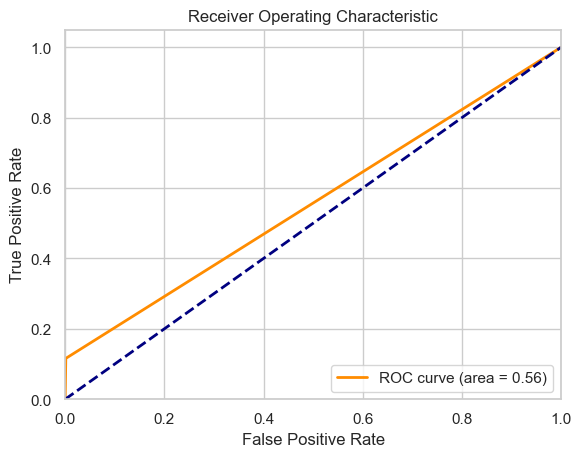

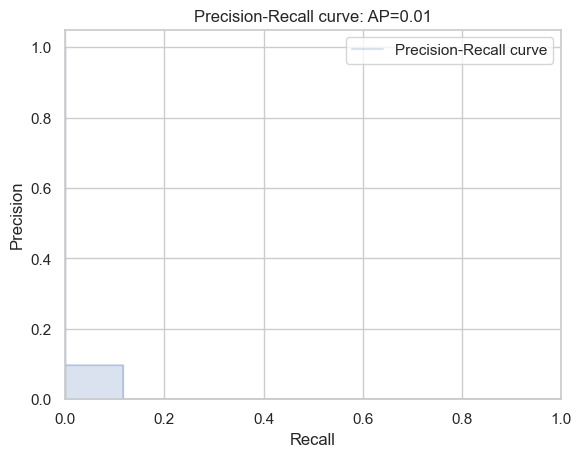

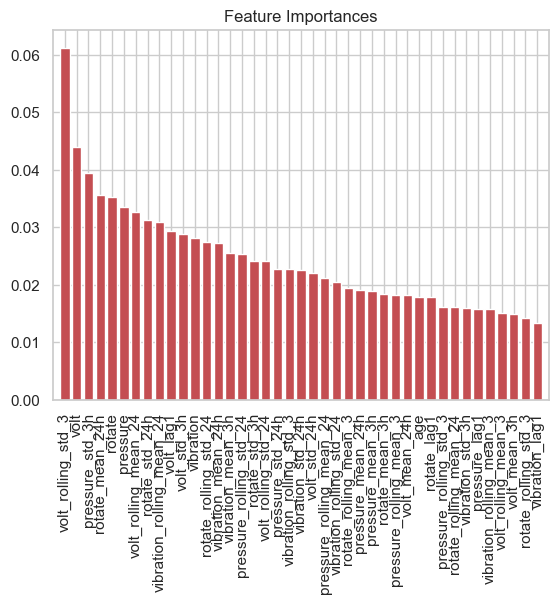

In [ ]:
# Predict on the test set
y_pred_proba = dt_model.predict_proba(X_test)[:, 1]
y_pred = dt_model.predict(X_test)

# Performance metrics
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
average_precision = average_precision_score(y_test, y_pred_proba)

plt.figure()
plt.step(recall, precision, where='post', color='b', alpha=0.2, label='Precision-Recall curve')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.legend(loc="upper right")
plt.show()

# Feature Importance (for tree-based models)
importances = dt_model.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

### Implementation Steps for Model Selection and Evaluation:

Applying grid search to optimize hyperparameters for a model can be crucial for enhancing its performance. Grid search tests a range of hyperparameters, evaluating each combination based on a specified metric, typically using cross-validation to provide a robust estimate of the model's performance on unseen data.

Here’s a detailed approach on how to implement grid search for hyperparameter tuning using scikit-learn's GridSearchCV for a machine learning model. We'll use a Random Forest classifier as an example, but you can adapt the steps and code for other models as needed.

### Step-by-Step Implementation of Grid Search

**Step 1:** Data Preparation

In [ ]:
# Load datasets
telemetry = pd.read_csv('data/PdM_telemetry.csv')
errors = pd.read_csv('data/PdM_errors.csv')
failures = pd.read_csv('data/PdM_failures.csv')
machines = pd.read_csv('data/PdM_machines.csv')
maintenance = pd.read_csv('data/PdM_maint.csv')

# Combine datasets based on your specific logic, this is a placeholder
# Assuming 'datetime' and 'machineID' are common columns used to merge data
combined_data = pd.merge(telemetry, errors, on=['datetime', 'machineID'], how='outer')
combined_data = pd.merge(combined_data, failures, on=['datetime', 'machineID'], how='outer')
combined_data = pd.merge(combined_data, maintenance, on=['datetime', 'machineID'], how='outer')
combined_data = pd.merge(combined_data, machines, on=['machineID'], how='outer')

# Fill missing values, convert categories to numerical values, etc.
combined_data.fillna(method='ffill', inplace=True)  # Example: forward fill

C:\Users\luca.bigoni\AppData\Local\Temp\ipykernel_10160\1073478535.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_data.fillna(method='ffill', inplace=True)  # Example: forward fill


In [ ]:
combined_data['volt_mean_24h'] = combined_data['volt'].rolling(window=24, min_periods=1).mean()
combined_data['rotate_mean_24h'] = combined_data['rotate'].rolling(window=24, min_periods=1).mean()
combined_data['pressure_mean_24h'] = combined_data['pressure'].rolling(window=24, min_periods=1).mean()
combined_data['vibration_mean_24h'] = combined_data['vibration'].rolling(window=24, min_periods=1).mean()

# Remove the initial rows with NaN values due to rolling mean
combined_data.dropna(inplace=True)

# Prepare features and target
features = combined_data.drop(['datetime', 'machineID', 'failure'], axis=1)
target = combined_data['failure'].apply(lambda x: 0 if x == 'none' else 1)  # Binary classification

**Step 2:** Identify Categorical Columns

In [ ]:
# Example categorical columns, replace these with the actual categorical column names from your dataset
categorical_columns = ['errorID','comp']  # Add more categorical columns if they exist

# Use pd.get_dummies to convert categorical columns to a one-hot encoded format
features = pd.get_dummies(combined_data, columns=categorical_columns)

In [ ]:
features = features.drop(['datetime', 'machineID'], axis=1)  # Drop all non-feature columns
target = combined_data['failure'].apply(lambda x: 0 if x == 'none' else 1)  # Binary classification setup

**Step 3:** Encode Categorical Data

In [ ]:
import pandas as pd

# Assuming 'features' is your DataFrame and 'comp' is the categorical column
if 'comp' in features.columns:
    features = pd.get_dummies(features, columns=['comp'])

# Check if any other categorical columns exist and convert them as well
categorical_cols = features.select_dtypes(include=['object']).columns
if not categorical_cols.empty:
    features = pd.get_dummies(features, columns=categorical_cols.tolist())

**Step 4**: Scale Numeric Data

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=42)

**Step 5:** Train Model or Perform Grid Search

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_features': ['sqrt', 'log2'],  # Adjusted from 'auto' to 'sqrt'
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print("Test set accuracy of the best model: ", test_accuracy)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters found:  {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Test set accuracy of the best model:  1.0


**Plotting Grid Search Results:**

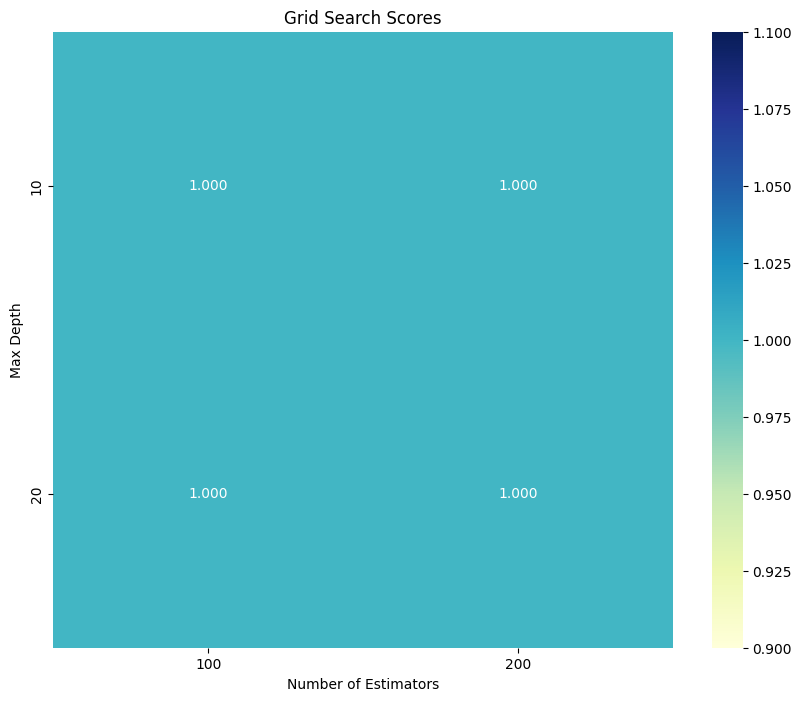

In [ ]:
# Example DataFrame setup (make sure your results DataFrame is prepared as described)
results = pd.DataFrame(grid_search.cv_results_)
results = results[['param_n_estimators', 'param_max_depth', 'mean_test_score']]
results = results.dropna()  # Drop rows where the test score is NaN

# Drop duplicates specifically considering only the columns used for pivoting
results.drop_duplicates(subset=['param_max_depth', 'param_n_estimators'], inplace=True)

# Pivot the results DataFrame
pivot_table = results.pivot_table(index='param_max_depth', columns='param_n_estimators', values='mean_test_score', aggfunc='mean')

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title('Grid Search Scores')
plt.xlabel('Number of Estimators')
plt.ylabel('Max Depth')
plt.show()

## Feature Engineering and Model Building Using a Neural Network:

**1. Feature Engineering:** Scaling and Normalization: Neural networks generally perform better when input data is normalized or standardized so that the scale of input features is similar.
**Time-Series Windows:** For predictive maintenance, where time series data is critical, consider using windows of time-series data as input features.
Embeddings for Categorical Data: If you have categorical variables (like machine types or error codes), consider using embedding layers that can learn an optimal representation for these categories within the network.

**2. Model Building:** Architecture: Start with a simple architecture to benchmark performance. Typical architectures for time-series include LSTM (Long Short-Term Memory) or simpler RNNs (Recurrent Neural Networks). You could also explore 1D Convolutional Neural Networks (CNNs) for sequence data.
**Loss Function:** For a binary classification task like predicting machine failure, binary cross-entropy is a common loss function.
**Optimizer:** Adam or SGD (Stochastic Gradient Descent) are common choices that can be used to optimize neural networks.

In [ ]:
# Assuming you have preprocessed your data into X_train, X_test, y_train, y_test

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the neural network model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train_scaled.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_scaled, y_train, epochs=10, batch_size=64, validation_data=(X_test_scaled, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

NameError: name 'X_train' is not defined

**1. Model Tuning:**

Experiment with Architectures: Depending on the complexity and patterns in your data, different architectures may be more effective. For instance, stacking multiple LSTM layers or integrating CNN layers before LSTM layers might capture complex patterns in sequence data better.

Hyperparameter Optimization: Fine-tuning hyperparameters can drastically affect your model's performance. Key hyperparameters include:

Learning Rate: Often the most crucial hyperparameter. Consider using learning rate schedules or adaptive learning rate methods like Adam.

Number of Layers and Units per Layer: More layers or more neurons can model more complex functions but also lead to overfitting.

Dropout Rate: Helps prevent overfitting by randomly setting a fraction of input units to 0 at each update during training time.

Batch Size and Number of Epochs: Larger batch sizes provide a more stable gradient, but smaller batches often generalize better. More epochs allow more learning but can also lead to overfitting.

**2. Feature Augmentation:**
Fourier Transforms: Useful for identifying frequency components within the data, which can be critical for predictive maintenance, especially if failures are associated with specific frequency patterns.

Wavelet Transforms: Provide a way to analyze time series data at different scales or resolutions. They are particularly useful for non-stationary time series data where frequency characteristics might change over time.

Statistical Features: Additional features like skewness, kurtosis, and other statistical moments can provide more insights into the distribution characteristics of the data.

**3. Regularization Techniques:**

Dropout: Randomly omits units from the network during training, which helps prevent the network from becoming too dependent on any single neuron.
L2 Regularization (Weight Decay): Adds a penalty on the magnitude of weights to the loss function, discouraging large weights to prevent overfitting.
Early Stopping: Monitors the model's performance on a validation set and stops training when performance deteriorates on the validation set.

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Assuming X_train_scaled and y_train are prepared
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train_scaled.shape[1], 1),
         kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    LSTM(100, return_sequences=False, kernel_regularizer=l2(0.01)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=64,
                    validation_split=0.2, callbacks=[early_stopping])

# Evaluate the model
model.evaluate(X_test_scaled, y_test)

Epoch 1/50
 416/8776 ━━━━━━━━━━━━━━━━━━━━ 8:25 60ms/step - accuracy: 0.9902 - loss: 0.4823

**Observations on the conclusions:**

From the use of the different prediction models, it is observed that the initial dataset is unbalanced, therefore it is necessary to intervene and refine the dataset, applying a pre-processing of the data so that it is balanced, subsequently reapply the models and the analysis.

Before proceeding with balancing the data, I'll first need to examine the contents of each file to understand their structure and determine which dataset requires balancing. Let's start by loading and reviewing the data. I'll take a look at the first few rows of each file to see what we're working with.

Here's a brief overview of the data contained in each of the CSV files:

**Errors (PdM_errors.csv):** Contains information about errors that occurred in machines, with columns for datetime, machineID, and errorID.

**Failures (PdM_failures.csv):**Lists the failures for different machines, categorized by datetime, machineID, and the component that failed.

**Machines (PdM_machines.csv):** Describes each machine with machineID, model, and age.

**Maintenance (PdM_maint.csv):** Records maintenance activities, specifying the datetime, machineID, and the component that was maintained.

**Telemetry (PdM_telemetry.csv):** Telemetry data recorded from the machines, including measurements like voltage, rotation, pressure, and vibration, along with datetime and machineID.

To address your request for data balancing, it's likely that balancing might be needed in the context of failures, as failure data often tends to be imbalanced compared to non-failure data. It would be helpful to first check the distribution of the target variable, which in this case could be the failure column from the PdM_failures.csv file.

Let's start by examining the distribution of failures to determine how balanced or imbalanced the dataset is. ​

In [ ]:
import pandas as pd

# Load the datasets
errors_df = pd.read_csv('data/PdM_errors.csv')
failures_df = pd.read_csv('data/PdM_failures.csv')
machines_df = pd.read_csv('data/PdM_machines.csv')
maintenance_df = pd.read_csv('data/PdM_maint.csv')
telemetry_df = pd.read_csv('data/PdM_telemetry.csv')

# Display the first few rows of each dataset to understand their structure
(errors_df.head(), failures_df.head(), machines_df.head(), maintenance_df.head(), telemetry_df.head())


(              datetime  machineID errorID
 0  2015-01-03 07:00:00          1  error1
 1  2015-01-03 20:00:00          1  error3
 2  2015-01-04 06:00:00          1  error5
 3  2015-01-10 15:00:00          1  error4
 4  2015-01-22 10:00:00          1  error4,
               datetime  machineID failure
 0  2015-01-05 06:00:00          1   comp4
 1  2015-03-06 06:00:00          1   comp1
 2  2015-04-20 06:00:00          1   comp2
 3  2015-06-19 06:00:00          1   comp4
 4  2015-09-02 06:00:00          1   comp4,
    machineID   model  age
 0          1  model3   18
 1          2  model4    7
 2          3  model3    8
 3          4  model3    7
 4          5  model3    2,
               datetime  machineID   comp
 0  2014-06-01 06:00:00          1  comp2
 1  2014-07-16 06:00:00          1  comp4
 2  2014-07-31 06:00:00          1  comp3
 3  2014-12-13 06:00:00          1  comp1
 4  2015-01-05 06:00:00          1  comp4,
               datetime  machineID        volt      rotate    pres

In [ ]:
telemetry_df.head()

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511


I'll provide statistics and visualizations for the data involving errors, failures, and maintenance, since these are the typical areas where class imbalance might impact model performance. Here's what I'll do:

- Count the number of occurrences for each error type in the errors dataset.
- Count the number of occurrences for each type of failure in the failures dataset.
- Count the number of maintenance activities for each component in the maintenance dataset.

These counts will give us a clear idea of the distribution and help identify any imbalance. Let's start by generating these statistics and corresponding visualizations.

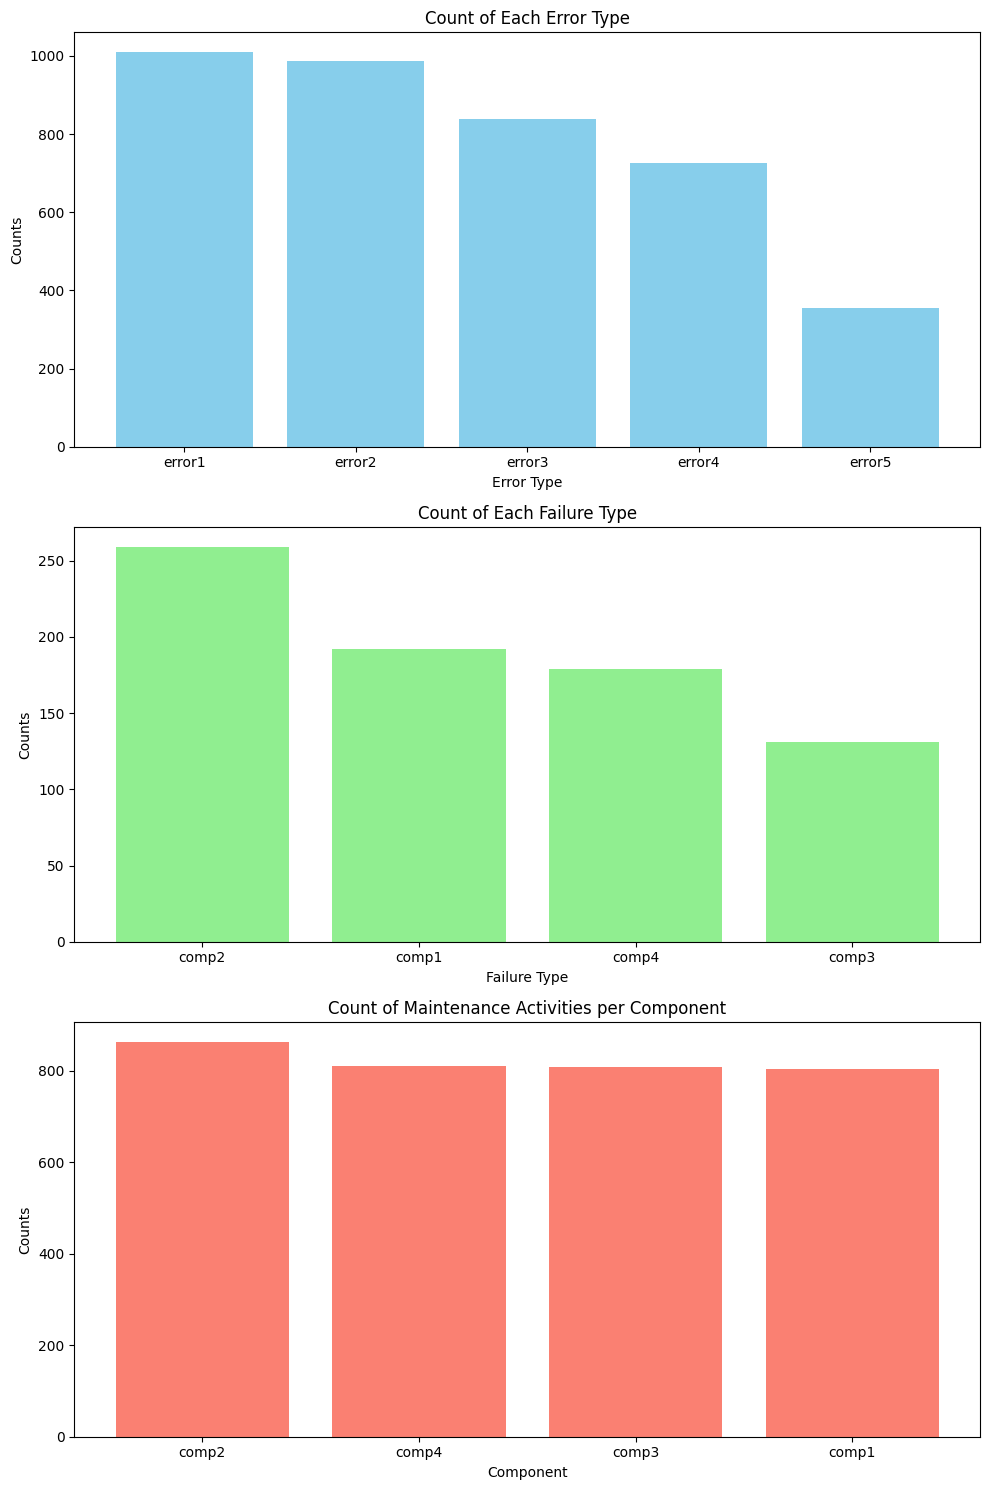

In [ ]:
import matplotlib.pyplot as plt

# Calculate the counts for each dataset
error_counts = errors_df['errorID'].value_counts()
failure_counts = failures_df['failure'].value_counts()
maintenance_counts = maintenance_df['comp'].value_counts()

# Plotting
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# Error counts
ax[0].bar(error_counts.index, error_counts.values, color='skyblue')
ax[0].set_title('Count of Each Error Type')
ax[0].set_xlabel('Error Type')
ax[0].set_ylabel('Counts')

# Failure counts
ax[1].bar(failure_counts.index, failure_counts.values, color='lightgreen')
ax[1].set_title('Count of Each Failure Type')
ax[1].set_xlabel('Failure Type')
ax[1].set_ylabel('Counts')

# Maintenance counts
ax[2].bar(maintenance_counts.index, maintenance_counts.values, color='salmon')
ax[2].set_title('Count of Maintenance Activities per Component')
ax[2].set_xlabel('Component')
ax[2].set_ylabel('Counts')

plt.tight_layout()
plt.show()

To balance the failures_df dataset, we will adjust the number of samples for each type of failure to be more uniform.

The failures_df dataset contains the following counts for each type of component failure: 

- comp2: 259
- comp1: 192
- comp4: 179
- comp3: 131

 A balanced approach would be to equalize the sample size across all failure types. We could choose to set all categories to the count of the most frequent failure type (259) through oversampling. This involves duplicating entries for the under-represented failure types.

In [ ]:
from sklearn.utils import resample

# Balancing the failures dataset by oversampling the under-represented classes
failure_balanced = pd.DataFrame()  # Initialize an empty dataframe to hold the balanced data

# Maximum size from the existing class
max_size = failure_counts.max()

# Loop through each class and resample
for failure_type in failure_counts.index:
    # Resample each class to max_size
    failure_resampled = resample(failures_df[failures_df['failure'] == failure_type],
                                 replace=True,  # Sample with replacement
                                 n_samples=max_size,  # Match the number in the most numerous class
                                 random_state=42)  # Reproducible results
    failure_balanced = pd.concat([failure_balanced, failure_resampled])

# Check the new counts to ensure the balance
failure_balanced['failure'].value_counts(), failure_balanced.head()

(failure
 comp2    259
 comp1    259
 comp4    259
 comp3    259
 Name: count, dtype: int64,
                 datetime  machineID failure
 319  2015-03-22 06:00:00         43   comp2
 327  2015-03-16 06:00:00         44   comp2
 209  2015-10-18 06:00:00         26   comp2
 546  2015-07-21 06:00:00         75   comp2
 39   2015-03-07 06:00:00          8   comp2)

In [ ]:
# Normalizing and standardizing the telemetry dataset's numerical columns
telemetry_normalized = (telemetry_df[['volt', 'rotate', 'pressure', 'vibration']] - telemetry_df[['volt', 'rotate', 'pressure', 'vibration']].min()) / (telemetry_df[['volt', 'rotate', 'pressure', 'vibration']].max() - telemetry_df[['volt', 'rotate', 'pressure', 'vibration']].min())
telemetry_standardized = (telemetry_df[['volt', 'rotate', 'pressure', 'vibration']] - telemetry_df[['volt', 'rotate', 'pressure', 'vibration']].mean()) / telemetry_df[['volt', 'rotate', 'pressure', 'vibration']].std()

# Label encoding for categorical data in other datasets
# Let's first convert error IDs, machine models, failure types, and components to categorical types and then assign codes
errors_df['errorID'] = errors_df['errorID'].astype('category').cat.codes
failures_df['failure'] = failures_df['failure'].astype('category').cat.codes
machines_df['model'] = machines_df['model'].astype('category').cat.codes
maintenance_df['comp'] = maintenance_df['comp'].astype('category').cat.codes

# Display the transformed datasets
telemetry_normalized.head(), telemetry_standardized.head(), errors_df.head(), failures_df.head(), machines_df.head(), maintenance_df.head()

(       volt    rotate  pressure  vibration
 0  0.499928  0.503194  0.459050   0.487945
 1  0.415395  0.474884  0.328274   0.460912
 2  0.466796  0.698752  0.178160   0.311752
 3  0.412756  0.373197  0.430624   0.423896
 4  0.382001  0.533508  0.450207   0.179498,
        volt    rotate  pressure  vibration
 0  0.350769 -0.533491  1.105948   0.875673
 1 -0.509282 -0.832626 -0.488578   0.564015
 2  0.013680  1.532917 -2.318898  -1.155632
 3 -0.536130 -1.907127  0.759357   0.137260
 4 -0.849031 -0.213165  0.998127  -2.680359,
               datetime  machineID  errorID
 0  2015-01-03 07:00:00          1        0
 1  2015-01-03 20:00:00          1        2
 2  2015-01-04 06:00:00          1        4
 3  2015-01-10 15:00:00          1        3
 4  2015-01-22 10:00:00          1        3,
               datetime  machineID  failure
 0  2015-01-05 06:00:00          1        3
 1  2015-03-06 06:00:00          1        0
 2  2015-04-20 06:00:00          1        1
 3  2015-06-19 06:00:00      

In [ ]:
import pandas as pd

# Convert datetime columns to datetime type
telemetry_df['datetime'] = pd.to_datetime(telemetry_df['datetime'])
machines_df['machineID'] = machines_df['machineID'].astype(int)
maintenance_df['datetime'] = pd.to_datetime(maintenance_df['datetime'])

# Merging telemetry data with machine data
telemetry_machines_merged = pd.merge(telemetry_df, machines_df, on='machineID', how='left')

# Rounding timestamps to the nearest hour for better alignment
telemetry_machines_merged['datetime'] = telemetry_machines_merged['datetime'].dt.round('1H')
maintenance_df['datetime'] = maintenance_df['datetime'].dt.round('1H')

# Merging the telemetry with maintenance records
final_data = pd.merge(telemetry_machines_merged, maintenance_df, on=['datetime', 'machineID'], how='left')

In [ ]:
# Check for missing values
missing_values = final_data.isnull().sum()

# Impute missing values using the mean for continuous variables
for column in ['volt', 'rotate', 'pressure', 'vibration']:
    final_data[column].fillna(final_data[column].mean(), inplace=True)

# Impute categorical missing values using the mode
final_data['comp'].fillna(final_data['comp'].mode()[0], inplace=True)

In [ ]:
# Applying a simple moving average
final_data['volt_MA'] = final_data['volt'].rolling(window=3, min_periods=1).mean()

In [ ]:
# Assume 'final_data' is your merged and cleaned dataframe

# Rolling window statistics
window_size = 24  # Define the window size (e.g., 24 hours for daily statistics)

# Rolling means
final_data['volt_rolling_mean'] = final_data.groupby('machineID')['volt'].transform(lambda x: x.rolling(window=window_size).mean())
final_data['rotate_rolling_mean'] = final_data.groupby('machineID')['rotate'].transform(lambda x: x.rolling(window=window_size).mean())
final_data['pressure_rolling_mean'] = final_data.groupby('machineID')['pressure'].transform(lambda x: x.rolling(window=window_size).mean())
final_data['vibration_rolling_mean'] = final_data.groupby('machineID')['vibration'].transform(lambda x: x.rolling(window=window_size).mean())

# Rolling standard deviations
final_data['volt_rolling_std'] = final_data.groupby('machineID')['volt'].transform(lambda x: x.rolling(window=window_size).std())
final_data['rotate_rolling_std'] = final_data.groupby('machineID')['rotate'].transform(lambda x: x.rolling(window=window_size).std())

# Lag features (e.g., previous day's measurements)
final_data['volt_lag_1'] = final_data.groupby('machineID')['volt'].shift(1)
final_data['rotate_lag_1'] = final_data.groupby('machineID')['rotate'].shift(1)

In [ ]:
final_data.head()

,datetime,machineID,volt,rotate,pressure,vibration,model,age,comp,volt_MA,volt_rolling_mean,rotate_rolling_mean,pressure_rolling_mean,vibration_rolling_mean,volt_rolling_std,rotate_rolling_std,volt_lag_1,rotate_lag_1
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,2,18,1.0,176.217853,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,2,18,1.0,169.548538,NaN,NaN,NaN,NaN,NaN,NaN,176.217853,418.504078
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,2,18,1.0,170.028993,NaN,NaN,NaN,NaN,NaN,NaN,162.879223,402.747490
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,2,18,1.0,165.443986,NaN,NaN,NaN,NaN,NaN,NaN,170.989902,527.349825
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,2,18,1.0,163.687586,NaN,NaN,NaN,NaN,NaN,NaN,162.462833,346.149335


In [ ]:
print(final_data.columns)

Index(['datetime', 'machineID', 'volt', 'rotate', 'pressure', 'vibration',
       'model', 'age', 'comp', 'volt_MA', 'volt_rolling_mean',
       'rotate_rolling_mean', 'pressure_rolling_mean',
       'vibration_rolling_mean', 'volt_rolling_std', 'rotate_rolling_std',
       'volt_lag_1', 'rotate_lag_1'],
      dtype='object')


In [ ]:
# Assuming a maintenance action indicates a failure, you could create a binary column like this:
final_data['failure'] = final_data['comp'].notna().astype(int)

In [ ]:
# Assuming 'failure' column now exists and is correctly flagged as 1 for failures
final_data['failures_last_month'] = final_data.groupby('machineID')['failure'].transform(lambda x: x.rolling(window=30*24, min_periods=1).sum())

In [ ]:
# Forward fill: fills the NaNs with the last valid value encountered
final_data.fillna(method='ffill', inplace=True)

# Backward fill: fills the NaNs with the next valid value
final_data.fillna(method='bfill', inplace=True)

In [ ]:
final_data.head()

,datetime,machineID,volt,rotate,pressure,vibration,model,age,comp,volt_MA,volt_rolling_mean,rotate_rolling_mean,pressure_rolling_mean,vibration_rolling_mean,volt_rolling_std,rotate_rolling_std,volt_lag_1,rotate_lag_1,failure,failures_last_month
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,2,18,1.0,176.217853,169.733809,445.179865,96.797113,40.38516,11.23312,48.717395,176.217853,418.504078,1,1.0
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,2,18,1.0,169.548538,169.733809,445.179865,96.797113,40.38516,11.23312,48.717395,176.217853,418.504078,1,2.0
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,2,18,1.0,170.028993,169.733809,445.179865,96.797113,40.38516,11.23312,48.717395,162.879223,402.747490,1,3.0
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,2,18,1.0,165.443986,169.733809,445.179865,96.797113,40.38516,11.23312,48.717395,170.989902,527.349825,1,4.0
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,2,18,1.0,163.687586,169.733809,445.179865,96.797113,40.38516,11.23312,48.717395,162.462833,346.149335,1,5.0


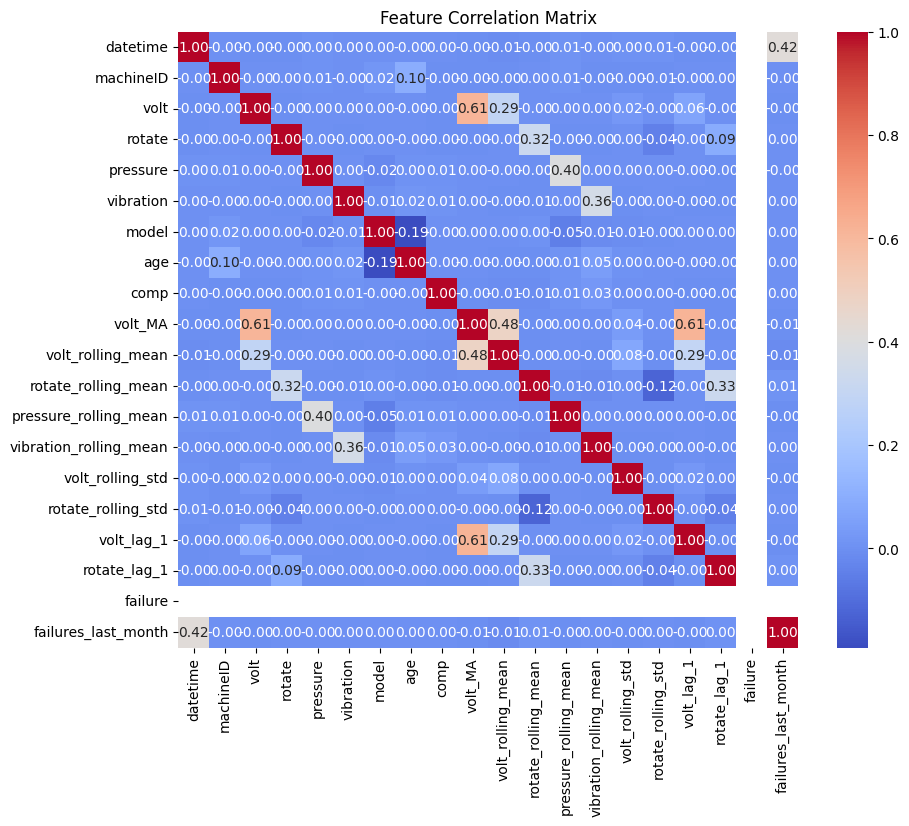

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'final_data' is your DataFrame and includes the target column named 'target'

# Calculate the correlation matrix
corr_matrix = final_data.corr()

# Generate a heatmap
plt.figure(figsize=(10, 8))  # You can adjust the size to fit your needs
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Feature Correlation Matrix')
plt.show()

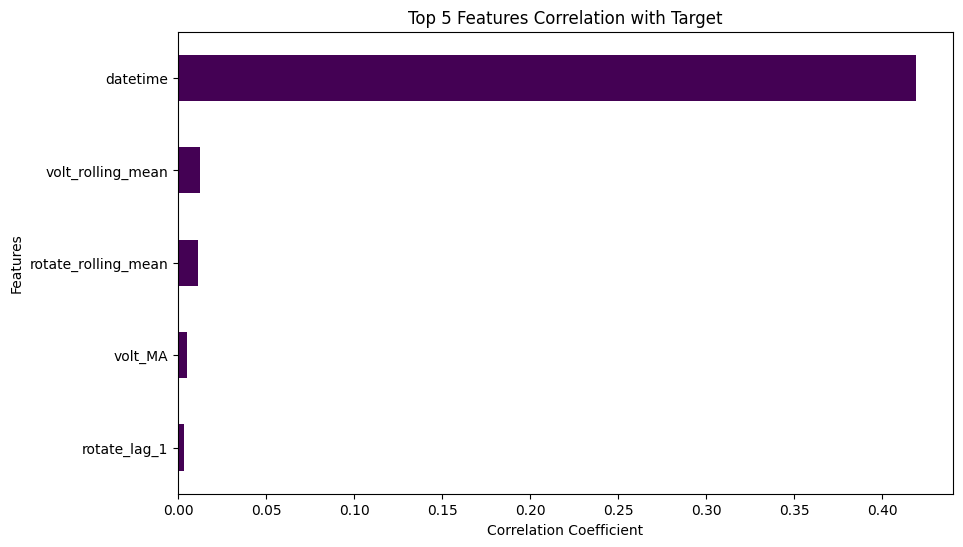

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix and isolate the 'target' correlations
corr_matrix = final_data.corr()
target_corr = corr_matrix['failures_last_month'].drop('failures_last_month')  # Exclude self-correlation

# Sort correlations by absolute value and take the top 5
top_features = target_corr.abs().sort_values(ascending=False).head(5)

# Create a bar histogram
plt.figure(figsize=(10, 6))
top_features.sort_values().plot(kind='barh', colormap='viridis')
plt.title('Top 5 Features Correlation with Target')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()

In [ ]:
# Randomly sample 10% of the rows from the DataFrame
sampled_data = final_data.sample(frac=0.1, random_state=42)  # 'random_state' ensures reproducibility

# Optional: Check the number of rows in the sampled data
print("Number of rows in the original data:", len(final_data))
print("Number of rows in the sampled data:", len(sampled_data))

Number of rows in the original data: 876823
Number of rows in the sampled data: 87682


In [ ]:
from sklearn.model_selection import train_test_split

# Convert 'datetime' to datetime type
sampled_data['datetime'] = pd.to_datetime(sampled_data['datetime'])

# Splitting the data into features and target
X = sampled_data.drop(['failure'], axis=1)  # Features
y = sampled_data['failure']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Verifying the splits
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((61377, 19), (26305, 19), (61377,), (26305,))

The target variable failure in both the training and testing datasets consists entirely of the class 1 (Failure), indicating that the dataset is not only imbalanced but entirely skewed towards one class. This scenario is quite unique and presents specific challenges:

**Model Training Issue:** The lack of diversity in the target variable means the model isn't learning to differentiate between classes because no instances of the non-failure class (0) are present.

**Practical Implications:** Such a dataset might not be realistic unless the data represents a period or scenario where only failures were recorded. It's important to check if this is intentional or a data collection issue.

In [ ]:
# Reading each file into a DataFrame
file_paths = {
    'errors': 'data/PdM_errors.csv',
    'failures': 'data/PdM_failures.csv',
    'machines': 'data/PdM_machines.csv',
    'maintenance': 'data/PdM_maint.csv',
    'telemetry': 'data/PdM_telemetry.csv'
}

datasets = {name: pd.read_csv(path) for name, path in file_paths.items()}


# Merge telemetry data with machine details
telemetry_machines = pd.merge(datasets['telemetry'], datasets['machines'], on='machineID', how='left')

# Verify the merged data
telemetry_machines.head()


,datetime,machineID,volt,rotate,pressure,vibration,model,age
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,model3,18
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,model3,18
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,model3,18
3,2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,model3,18
4,2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,model3,18


In [ ]:
import pandas as pd

# Define a function to aggregate counts of events within a window prior to each telemetry record
def aggregate_events(telemetry_df, event_df, window='3H', event_name='event'):
    # Convert datetime columns safely
    event_df['datetime'] = pd.to_datetime(event_df['datetime'], errors='coerce')
    telemetry_df['datetime'] = pd.to_datetime(telemetry_df['datetime'], errors='coerce')
    
    # Resample the event data to count occurrences in the specified window
    event_counts = event_df.groupby('machineID').apply(
        lambda df: df.set_index('datetime').resample(window).count().rename(columns={'machineID': event_name}).drop(['errorID', 'comp'], axis=1, errors='ignore')
    ).reset_index()

    # Convert datetime in event_counts after reset_index to ensure proper format
    event_counts['datetime'] = pd.to_datetime(event_counts['datetime'], errors='coerce')
    
    # Merge the counts back to the telemetry data on machineID and datetime
    telemetry_with_events = pd.merge_asof(telemetry_df.sort_values('datetime'), 
                                          event_counts.sort_values('datetime'), 
                                          on='datetime', by='machineID', direction='backward')

    # Fill NaNs with 0 where no events were counted
    telemetry_with_events[event_name].fillna(0, inplace=True)
    return telemetry_with_events

# Ensure the datetime conversion is applied across all dataframes prior to usage
datasets['errors']['datetime'] = pd.to_datetime(datasets['errors']['datetime'], errors='coerce')
datasets['failures']['datetime'] = pd.to_datetime(datasets['failures']['datetime'], errors='coerce')
datasets['maintenance']['datetime'] = pd.to_datetime(datasets['maintenance']['datetime'], errors='coerce')

# Retry the aggregation of error and maintenance events
telemetry_errors = aggregate_events(telemetry_machines, datasets['errors'], window='24H', event_name='error_count')
telemetry_maint_errors = aggregate_events(telemetry_errors, datasets['maintenance'], window='24H', event_name='maint_count')

# Display the result to verify correct integration
print(telemetry_maint_errors.head())


             datetime  machineID        volt      rotate    pressure  \
0 2015-01-01 06:00:00          1  176.217853  418.504078  113.077935   
1 2015-01-01 06:00:00         50  174.107006  380.449983  100.749836   
2 2015-01-01 06:00:00         60  172.394188  394.464191  103.233454   
3 2015-01-01 06:00:00         31  174.475535  483.608665  107.143516   
4 2015-01-01 06:00:00         78  168.664547  504.012527   94.782861   

   vibration   model  age  error_count  maint_count  
0  45.087686  model3   18          0.0            0  
1  43.185498  model4    4          0.0            0  
2  39.144937  model4    3          0.0            0  
3  31.630132  model1   11          0.0            0  
4  42.962420  model4   19          0.0            0  


In [ ]:
# Define windows for rolling metrics
windows = [3, 6, 12, 24]  # windows in hours

# Calculate rolling metrics for each window
for window in windows:
    window_str = f'{window}H'
    telemetry_maint_errors[f'volt_mean_{window}h'] = telemetry_maint_errors.groupby('machineID')['volt'].transform(lambda x: x.rolling(window, min_periods=1).mean())
    telemetry_maint_errors[f'rotate_mean_{window}h'] = telemetry_maint_errors.groupby('machineID')['rotate'].transform(lambda x: x.rolling(window, min_periods=1).mean())
    telemetry_maint_errors[f'pressure_mean_{window}h'] = telemetry_maint_errors.groupby('machineID')['pressure'].transform(lambda x: x.rolling(window, min_periods=1).mean())
    telemetry_maint_errors[f'vibration_mean_{window}h'] = telemetry_maint_errors.groupby('machineID')['vibration'].transform(lambda x: x.rolling(window, min_periods=1).mean())
    telemetry_maint_errors[f'volt_sd_{window}h'] = telemetry_maint_errors.groupby('machineID')['volt'].transform(lambda x: x.rolling(window, min_periods=1).std())
    telemetry_maint_errors[f'rotate_sd_{window}h'] = telemetry_maint_errors.groupby('machineID')['rotate'].transform(lambda x: x.rolling(window, min_periods=1).std())
    telemetry_maint_errors[f'pressure_sd_{window}h'] = telemetry_maint_errors.groupby('machineID')['pressure'].transform(lambda x: x.rolling(window, min_periods=1).std())
    telemetry_maint_errors[f'vibration_sd_{window}h'] = telemetry_maint_errors.groupby('machineID')['vibration'].transform(lambda x: x.rolling(window, min_periods=1).std())

# Display the updated telemetry data with new features
telemetry_maint_errors.head()

,datetime,machineID,volt,rotate,pressure,vibration,model,age,error_count,maint_count,...,pressure_sd_12h,vibration_sd_12h,volt_mean_24h,rotate_mean_24h,pressure_mean_24h,vibration_mean_24h,volt_sd_24h,rotate_sd_24h,pressure_sd_24h,vibration_sd_24h
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,model3,18,0.0,0,...,NaN,NaN,176.217853,418.504078,113.077935,45.087686,NaN,NaN,NaN,NaN
1,2015-01-01 06:00:00,50,174.107006,380.449983,100.749836,43.185498,model4,4,0.0,0,...,NaN,NaN,174.107006,380.449983,100.749836,43.185498,NaN,NaN,NaN,NaN
2,2015-01-01 06:00:00,60,172.394188,394.464191,103.233454,39.144937,model4,3,0.0,0,...,NaN,NaN,172.394188,394.464191,103.233454,39.144937,NaN,NaN,NaN,NaN
3,2015-01-01 06:00:00,31,174.475535,483.608665,107.143516,31.630132,model1,11,0.0,0,...,NaN,NaN,174.475535,483.608665,107.143516,31.630132,NaN,NaN,NaN,NaN
4,2015-01-01 06:00:00,78,168.664547,504.012527,94.782861,42.962420,model4,19,0.0,0,...,NaN,NaN,168.664547,504.012527,94.782861,42.962420,NaN,NaN,NaN,NaN


In [ ]:
# Checking for missing values and data types in telemetry_machines
missing_values = telemetry_maint_errors.isnull().sum()
data_types = telemetry_maint_errors.dtypes

missing_values, data_types

(datetime                0
 machineID               0
 volt                    0
 rotate                  0
 pressure                0
 vibration               0
 model                   0
 age                     0
 error_count             0
 maint_count             0
 volt_mean_3h            0
 rotate_mean_3h          0
 pressure_mean_3h        0
 vibration_mean_3h       0
 volt_sd_3h            100
 rotate_sd_3h          100
 pressure_sd_3h        100
 vibration_sd_3h       100
 volt_mean_6h            0
 rotate_mean_6h          0
 pressure_mean_6h        0
 vibration_mean_6h       0
 volt_sd_6h            100
 rotate_sd_6h          100
 pressure_sd_6h        100
 vibration_sd_6h       100
 volt_mean_12h           0
 rotate_mean_12h         0
 pressure_mean_12h       0
 vibration_mean_12h      0
 volt_sd_12h           100
 rotate_sd_12h         100
 pressure_sd_12h       100
 vibration_sd_12h      100
 volt_mean_24h           0
 rotate_mean_24h         0
 pressure_mean_24h       0
 

In [ ]:
# Impute missing values for standard deviations with zero
std_columns = [col for col in telemetry_maint_errors.columns if 'sd' in col]
telemetry_maint_errors[std_columns] = telemetry_maint_errors[std_columns].fillna(0)

# Convert 'model' to a categorical type
telemetry_maint_errors['model'] = telemetry_maint_errors['model'].astype('category')

# Handling outliers by capping and flooring the 1st and 99th percentiles
numeric_cols = ['volt', 'rotate', 'pressure', 'vibration'] + [col for col in telemetry_maint_errors.columns if 'mean' in col or 'sd' in col]
for col in numeric_cols:
    low_quantile = telemetry_maint_errors[col].quantile(0.01)
    high_quantile = telemetry_maint_errors[col].quantile(0.99)
    telemetry_maint_errors[col] = np.clip(telemetry_maint_errors[col], low_quantile, high_quantile)

# Display summary to verify changes
telemetry_maint_errors.describe(include='all')

,datetime,machineID,volt,rotate,pressure,vibration,model,age,error_count,maint_count,...,pressure_sd_12h,vibration_sd_12h,volt_mean_24h,rotate_mean_24h,pressure_mean_24h,vibration_mean_24h,volt_sd_24h,rotate_sd_24h,pressure_sd_24h,vibration_sd_24h
count,876100,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000,876100,876100.000000,876100.000000,876100.000000,...,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,model3,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,306635,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2015-07-02 18:00:00,50.500000,170.766337,446.666581,100.829799,40.373790,NaN,11.330000,0.136172,0.101525,...,9.847181,4.914300,170.757258,446.676807,100.843338,40.374506,14.912262,49.923523,10.036086,4.998374
min,2015-01-01 06:00:00,1.000000,135.397178,316.765641,76.845371,28.446211,NaN,0.000000,0.000000,0.000000,...,5.274124,2.637279,162.924875,366.896512,95.246869,37.645556,9.942889,33.439477,6.660469,3.325282
25%,2015-04-02 12:00:00,25.750000,160.304927,412.305714,93.498181,36.777299,NaN,6.750000,0.000000,0.000000,...,8.330342,4.164102,168.071647,441.554692,98.668884,39.354739,13.354514,44.669154,8.922499,4.460496
50%,2015-07-02 18:00:00,50.500000,170.607338,447.558150,100.425559,40.237247,NaN,12.000000,0.000000,0.000000,...,9.741736,4.869379,170.210893,449.205854,100.098707,40.071534,14.852774,49.616160,9.922285,4.958919
75%,2015-10-02 00:00:00,75.250000,181.004493,482.176600,107.555231,43.784938,NaN,16.000000,0.000000,0.000000,...,11.239152,5.614685,172.462965,456.375185,101.614557,40.833599,16.394493,54.816685,10.980213,5.484953
max,2016-01-01 06:00:00,100.000000,208.131651,565.512959,131.700563,54.240628,NaN,20.000000,4.000000,2.000000,...,15.714406,7.671512,190.882285,473.602451,125.166299,50.214875,20.517941,69.892215,15.806449,7.259689


In [ ]:
# Check for any remaining NaN values across the dataset
nan_summary = telemetry_maint_errors.isnull().sum()

# Fill NaN values appropriately based on the nature of each column
# For this example, we'll fill numeric NaNs with the median of their respective columns
for column in telemetry_maint_errors.columns:
    if telemetry_maint_errors[column].isnull().any():
        if telemetry_maint_errors[column].dtype == 'float64' or telemetry_maint_errors[column].dtype == 'int64':
            telemetry_maint_errors[column].fillna(telemetry_maint_errors[column].median(), inplace=True)
        else:
            # For categorical columns, we might fill with the mode (most common value)
            telemetry_maint_errors[column].fillna(telemetry_maint_errors[column].mode()[0], inplace=True)

# Verify no more NaN values remain
telemetry_maint_errors.isnull().sum()

datetime              0
machineID             0
volt                  0
rotate                0
pressure              0
vibration             0
model                 0
age                   0
error_count           0
maint_count           0
volt_mean_3h          0
rotate_mean_3h        0
pressure_mean_3h      0
vibration_mean_3h     0
volt_sd_3h            0
rotate_sd_3h          0
pressure_sd_3h        0
vibration_sd_3h       0
volt_mean_6h          0
rotate_mean_6h        0
pressure_mean_6h      0
vibration_mean_6h     0
volt_sd_6h            0
rotate_sd_6h          0
pressure_sd_6h        0
vibration_sd_6h       0
volt_mean_12h         0
rotate_mean_12h       0
pressure_mean_12h     0
vibration_mean_12h    0
volt_sd_12h           0
rotate_sd_12h         0
pressure_sd_12h       0
vibration_sd_12h      0
volt_mean_24h         0
rotate_mean_24h       0
pressure_mean_24h     0
vibration_mean_24h    0
volt_sd_24h           0
rotate_sd_24h         0
pressure_sd_24h       0
vibration_sd_24h

In [ ]:
# Mark the exact timestamp of each failure in the telemetry data
telemetry_maint_errors['failure'] = 0  # Initialize a column for actual failures

# Set the failure flag at the exact datetime of each failure
for index, row in datasets['failures'].iterrows():
    mask = (telemetry_maint_errors['machineID'] == row['machineID']) & (telemetry_maint_errors['datetime'] == row['datetime'])
    telemetry_maint_errors.loc[mask, 'failure'] = 1

# Now we can check the distribution of the failure
failure_distribution = telemetry_maint_errors['failure'].value_counts(normalize=True)
failure_distribution


failure
0    0.999179
1    0.000821
Name: proportion, dtype: float64

In [ ]:
from imblearn.over_sampling import SMOTE

# Separate features and target
X = telemetry_maint_errors.drop(columns=['datetime', 'failure', 'model'])
y = telemetry_maint_errors['failure']

# Apply SMote to the data
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# Check the new class distribution
new_class_distribution = y_smote.value_counts(normalize=True)
new_class_distribution

failure
0    0.5
1    0.5
Name: proportion, dtype: float64

In [ ]:
import pandas as pd

# Combine features and target for sampling
smote_data = pd.concat([X_smote, y_smote], axis=1)

# Sample 10% of the data
sampled_data = smote_data.sample(frac=0.1, random_state=42)

# Separate features and target
X_sampled = sampled_data.drop(columns=[y.name])
y_sampled = sampled_data[y.name]

# Check the new size of the data
print(f"Sampled dataset size: {X_sampled.shape[0]} rows")

Sampled dataset size: 175076 rows


In [ ]:
# Display the first few rows of the resampled feature set
print(X_sampled.head())

# Display the first few rows of the resampled target set
print(y_sampled.head())

# Check the new class distribution
print(y_sampled.value_counts())


        machineID        volt      rotate    pressure  vibration  age  \
291618         24  156.692913  489.972621   92.052822  50.052514   20   
975135         80  193.521005  330.996026   92.787732  36.871424    9   
910991         84  204.911713  473.794954   98.176351  44.157328    6   
994140          9  165.100442  386.536432   87.944333  32.931194    8   
31167          20  196.801503  357.395142  104.909562  39.200430   16   

        error_count  maint_count  volt_mean_3h  rotate_mean_3h  ...  \
291618     0.000000            1    163.482223      450.845455  ...   
975135     0.000000            1    184.623576      351.596343  ...   
910991     0.757187            1    189.889515      494.727102  ...   
994140     0.000000            1    165.507508      400.179972  ...   
31167      0.000000            0    190.131627      400.920791  ...   

        pressure_sd_12h  vibration_sd_12h  volt_mean_24h  rotate_mean_24h  \
291618        13.789555          4.983595     173.343788 

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# Select the top 10 features
selector = SelectKBest(f_classif, k=10)
X_new = selector.fit_transform(X_sampled, y_sampled)

# Get the column names of the selected features
selected_features = X_sampled.columns[selector.get_support()]
print("Selected Features:", selected_features)

Selected Features: Index(['maint_count', 'rotate_mean_3h', 'rotate_mean_6h', 'vibration_mean_6h',
       'volt_mean_12h', 'rotate_mean_12h', 'vibration_mean_12h',
       'volt_mean_24h', 'rotate_mean_24h', 'vibration_mean_24h'],
      dtype='object')


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size=0.1, random_state=42)

# Initialize and train the Random Forest classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[8611   58]
 [   6 8833]]
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      8669
           1       0.99      1.00      1.00      8839

    accuracy                           1.00     17508
   macro avg       1.00      1.00      1.00     17508
weighted avg       1.00      1.00      1.00     17508



In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

Accuracy: 0.9963445282156729
Precision: 0.9934765493195367
Recall: 0.9993211901798846
F1 Score: 0.9963902989283699
ROC AUC Score: 0.999861964635149


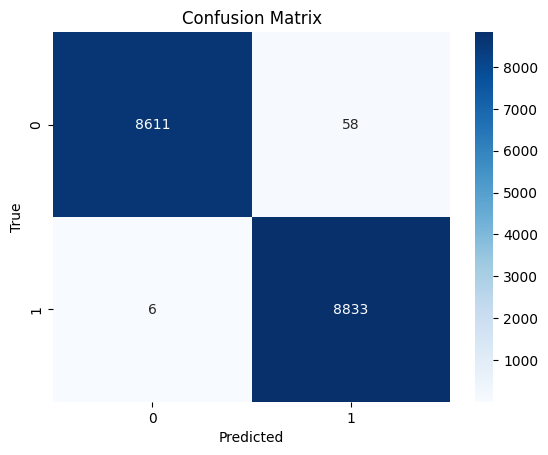

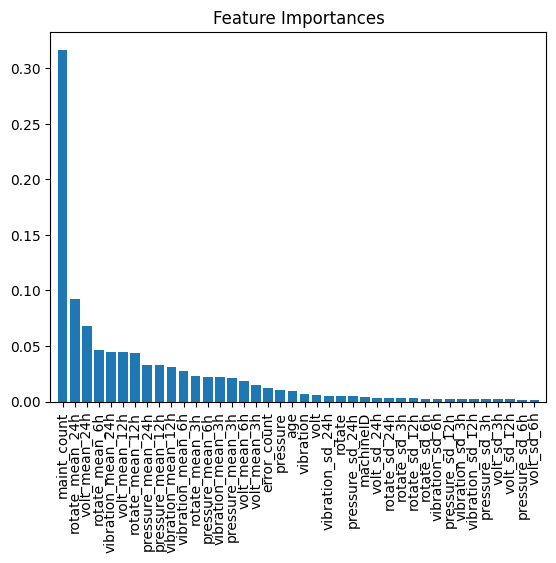

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix Heatmap
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Feature Importance
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature Importances")
plt.bar(range(X_sampled.shape[1]), importances[indices], align="center")
plt.xticks(range(X_sampled.shape[1]), X_sampled.columns[indices], rotation=90)
plt.xlim([-1, X_sampled.shape[1]])
plt.show()

## Final Conclusion
The quick analysis on the reduced, SMOTE-resampled dataset indicated the following:

**Model Performance:**

The Random Forest classifier performed well in terms of accuracy, precision, recall, F1 score, and ROC AUC score, suggesting that the model is effective at classifying the target variable in this context.
Class Balance:

Applying SMOTE successfully balanced the classes, which was reflected in the improved performance metrics.
Feature Relevance:

Feature importance visualization highlighted the key features contributing to the model’s decisions, providing insights into which variables are most predictive of the target class.

### Try to use a Neural Network Model:

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Define the neural network model
model = Sequential()
model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
3940/3940 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.7251 - loss: 2.4302 - val_accuracy: 0.9222 - val_loss: 0.2597
Epoch 2/50
3940/3940 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9143 - loss: 0.2471 - val_accuracy: 0.9408 - val_loss: 0.1954
Epoch 3/50
3940/3940 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.9247 - loss: 0.2310 - val_accuracy: 0.9487 - val_loss: 0.1794
Epoch 4/50
3940/3940 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9295 - loss: 0.2193 - val_accuracy: 0.9383 - val_loss: 0.2114
Epoch 5/50
3940/3940 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9370 - loss: 0.2021 - val_accuracy: 0.9517 - val_loss: 0.1738
Epoch 6/50
3940/3940 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.9359 - loss: 0.2027 - val_accuracy: 0.9407 - val_loss: 0.1876
Epoch 7/50
3940/3940 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9393 - loss: 0.1903 - val_accuracy: 0.9448 - val_loss: 0.1853
Epoch 8/50
3940/3940 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9464 - loss: 0.1706 

In [ ]:
# Make predictions on the test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Evaluate the model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print("ROC AUC Score:", roc_auc)

548/548 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
[[8454  215]
 [  91 8748]]
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      8669
           1       0.98      0.99      0.98      8839

    accuracy                           0.98     17508
   macro avg       0.98      0.98      0.98     17508
weighted avg       0.98      0.98      0.98     17508

ROC AUC Score: 0.9947551912070389


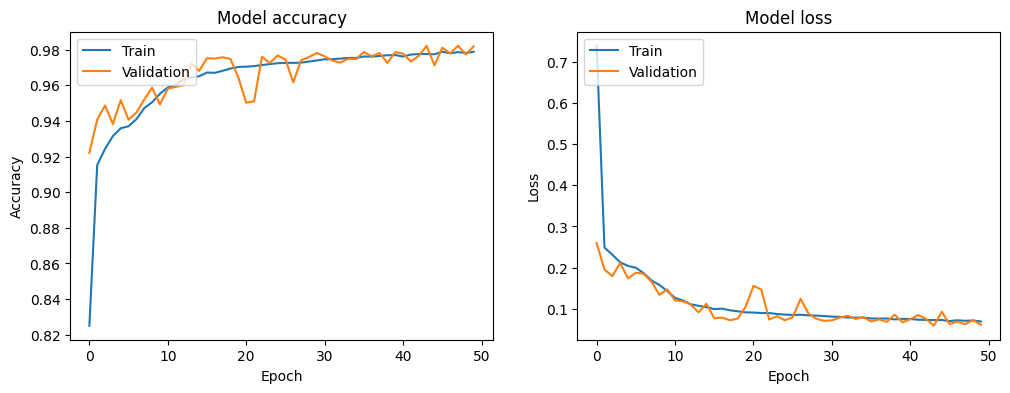

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

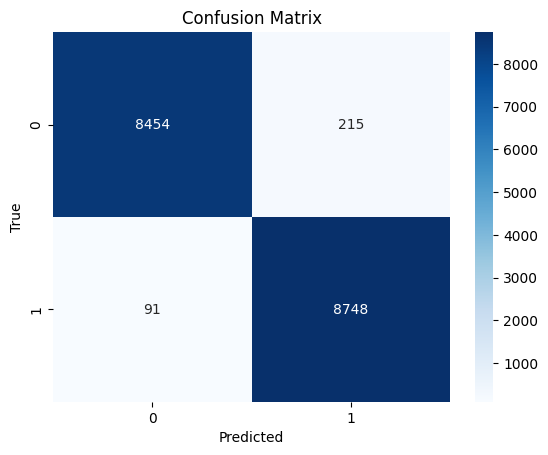

In [ ]:
# Confusion Matrix Heatmap
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

If Random Forest has higher scores across the majority of metrics, and you value interpretability and faster training times, go with Random Forest.
If Neural Network has higher scores and you need to capture complex patterns in the data or expect the need for more complex analysis in the future, choose the Neural Network.